In [328]:
import os

In [329]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [330]:
os.chdir("../")

In [331]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml'

In [332]:
proj_link = 'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'
os.chdir(proj_link)

In [333]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir : Path
    test_data_path: Path
    model_path: Path
    preprocessor_path : Path
    all_params : dict
    metric_file_name: Path
    target_column: str
    mlflow_uri: str
    xgb_encoder: Path
    sm_model: Path
    rf_model: Path
    rf_processor: Path
    xgb_processor: Path
    xgb_model: Path
    
    
    
    






In [334]:
from clientClassifier.constants import *    
from clientClassifier.utils.common import read_yaml, create_directories, save_json

In [335]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config['artifacts_root']])
        
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config['model_evaluation']
        params = self.params['xgb_classifier']
        schema = self.schema['TARGET_COLUMN']
        
        create_directories([config['root_dir']])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config['root_dir']),
            test_data_path=Path(config['test_data_path']),
            model_path=Path(config['model_path']),
            rf_model = Path(config['rf_model']),
            rf_processor  = Path(config['rf_processor']),
            preprocessor_path = Path(config['preprocessor_path']),
            xgb_encoder= Path(config['xgb_encoder']),
            xgb_model= Path(config['xgb_model']),   
            sm_model = Path(config['sm_model']),
            xgb_processor = Path(config['xgb_processor']),  
            all_params=params,
            metric_file_name=Path(config['metric_file_name']),
            target_column=schema.name,
            mlflow_uri="https://dagshub.com/richardmukechiwa/client-subscription-prediction.mlflow"
        )
        
        return model_evaluation_config
                
          

In [336]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import joblib
import mlflow 
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import shap







In [ ]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()

        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="xgb_classification_report")

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        
        model = joblib.load(self.config.xgb_model)
        processor = joblib.load(self.config.xgb_processor)
        encoder = joblib.load(self.config.xgb_encoder)
    

        test_x = test_data.drop(self.config.target_column, axis=1)
        test_y = test_data[self.config.target_column]
        
        #label encoding the target variable
        test_y = encoder.transform(test_y)
        

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        mlflow.set_experiment("classification_with_xgbclassifier")
        

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            #processing = model.transform(test_x)
            processed = processor.transform(test_x)
            predicted_qualities = model.predict(processed)

            accuracy, precision, recall, f1 = self.eval_metrics(test_y, predicted_qualities)

            model_name = "xgb_classifier" 

            scores = {
                "model_name": model_name,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

            save_json(path=Path(self.config.metric_file_name), data=scores)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

            class_names =encoder.classes_
            self.log_confusion_matrix(test_y, predicted_qualities, class_names)
            self.log_classification_report(test_y, predicted_qualities, class_names)

            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="XGB ClassificationModel")
            else:
                mlflow.sklearn.log_model(model, "model")




    def feature_importance(self):
        
        test_data = pd.read_csv(self.config.test_data_path)
        
      
        
        model = joblib.load(self.config.xgb_model)
        processor = joblib.load(self.config.xgb_processor)
        
        test_x = test_data.drop(self.config.target_column, axis=1)
        
        processed = processor.transform(test_x)
        
        print(processed.head())
        
        # Create SHAP explainer
        explainer = shap.TreeExplainer(model)

        # Use evaluation/test set ideally
        shap_values = explainer.shap_values(processed)

        # Plot SHAP summary
        shap.summary_plot(shap_values, processed)
        
        # Using in built feat selection
       
        #model.feature_importance_(model, importance_type='gain')
        #plt.title('XGBoost Built-in Feature Importance')
        #plt.show()
        
        
        import matplotlib.pyplot as plt

        # 1. Get feature importance
        importance = model.get_booster().get_score(importance_type='gain')

        # 2. Sort features by importance
        importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

        # 3. Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(list(importance.keys()), list(importance.values()))
        plt.gca().invert_yaxis()  # Highest importance on top
        plt.title('XGBoost Built-in Feature Importance (gain)')
        plt.xlabel('Importance Score')
        plt.show()



[2025-04-26 16:29:28,847: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-26 16:29:28,853: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-26 16:29:28,858: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-26 16:29:28,860: INFO: common: created directory at: artifacts]
[2025-04-26 16:29:28,862: INFO: common: created directory at: artifacts/model_evaluation]
[2025-04-26 16:29:29,093: INFO: common: json file saved at: artifacts\model_evaluation\metrics.json]


2025/04/26 16:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   age           job  marital  education default  balance housing loan  \
0   51  entrepreneur  married  secondary     yes    -2082      no  yes   
1   50    management  married   tertiary      no     2881      no   no   
2   50    technician  married  secondary      no     1412      no   no   
3   37    management  married   tertiary      no        0     yes   no   
4   31        admin.   single  secondary      no      757      no   no   

    contact  day  month  campaign  previous poutcome   y  
0  cellular   28      7         6         0  unknown  no  
1  cellular    5      8         2         5    other  no  
2  cellular    6      8         3         0  unknown  no  
3   unknown    3      6        13         0  unknown  no  
4  cellular    3      2         2         0  unknown  no  


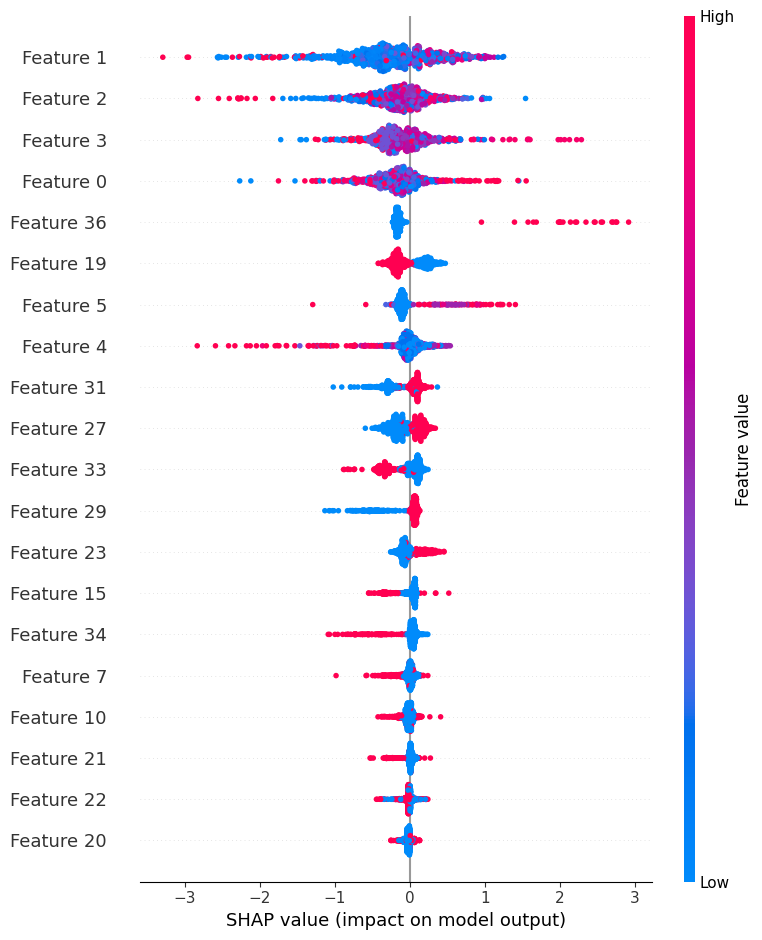

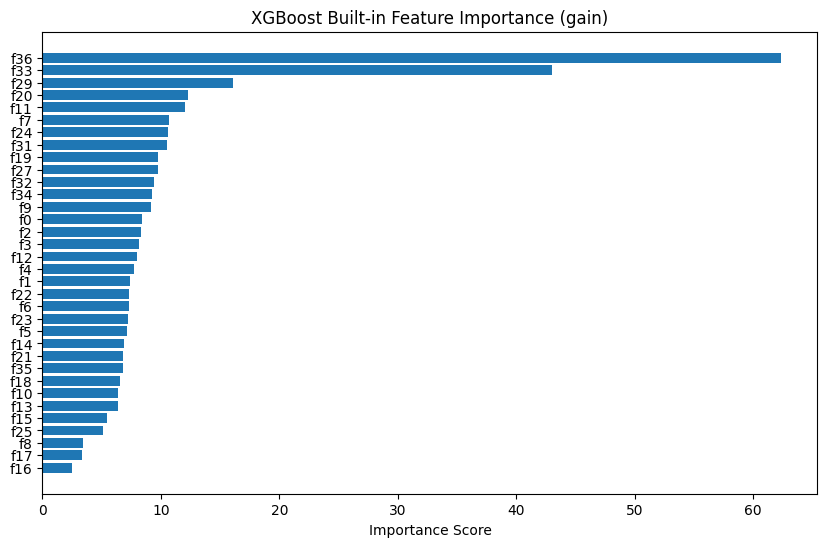

In [338]:

try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)  # Initialize model_evaluation
    model_evaluation.log_into_mlflow()
    model_evaluation.feature_importance()
 
except Exception as e:
    raise e